# HYSPLIT Modeling V1

This notebook represents an initial attempt to create a workflow for the HYSPLIT program. Currently in use are several functions within a related package called hypy.py. Please make sure to have this python file in the working directory of this notebook alongside a working installation of HYSPLIT and related NARR files.

In [1]:
#Libraries Utilized: 
#USE base env!

#Basic py: 
import numpy as np
import pandas as pd
import datetime
import os
import datetime

#Vis
import matplotlib.pyplot as plt

#Geo
import geopandas as gpd
import fiona
from shapely.geometry import Point
import descartes
import contextily as ctx #Basemaps 

#Custom Functions:
from hypy import HYSPLIT_configure, RSEI_merger, hysplit_input_conversion, chem_date_comb 

## Preprocess the TRI Data

In [4]:
#Load the Data
tri_df = pd.read_csv('TRI_Carc_FSRel_9099.csv').drop(columns ='Unnamed: 0')

#First let's load in the features to seperate the particles and gasses
TRI_chem_info = pd.read_csv('TRI_Carc_Half_Lives.csv')

#Keep only those entries with complete information
TRI_chems = TRI_chem_info.dropna(subset = ['CAS'])
TRI_chems = TRI_chems.rename(columns = {'Unnamed: 8':'Phase'})

#Merge that data onto the tri dataframe
tri_df = pd.merge(tri_df,TRI_chem_info,left_on ='CAS_No',right_on = 'CAS',how='left')
tri_df = tri_df.drop(columns = ['CAS','Chems','88-ONE-TIMERELEASE'])

In [6]:
fug_par_df.columns

Index(['CAS_No', 'Agent', 'Group', 'YEAR', 'TRIFD', 'FRSID', 'FACILITYNAME',
       'CITY', 'COUNTY', 'ST', 'ZIP', 'LATITUDE', 'LONGITUDE',
       'INDUSTRYSECTORCODE', 'INDUSTRYSECTOR', 'CHEMICAL', 'CAS#/COMPOUNDID',
       'METAL', 'CARCINOGEN', 'UNITOFMEASURE', '51-FUGITIVEAIR', '52-STACKAIR',
       'PRIMARYSIC', 'INDUSTRYSECTORCODE.1', 'PRODUCTIONWSTE(81-87)', 'Inert',
       '1/2 Life', 'Solubility in H2O', 'MW', 'Particle', 'Gas', 'Phase'],
      dtype='object')

In [8]:
#Seperate into the known differential modeling variants:
fug_par_df = tri_df[(tri_df['51-FUGITIVEAIR']>0) & (tri_df['Particle']==1)]
fug_gas_df = tri_df[(tri_df['51-FUGITIVEAIR']>0) & (tri_df['Gas']==1) ]
stack_par_df = tri_df[(tri_df['52-STACKAIR']>0) & (tri_df['Particle']==1)]
stack_gas_df = tri_df[(tri_df['52-STACKAIR']>0) & (tri_df['Gas']==1) ]

print('Fugitive Particle Releases shape: ' + str(fug_par_df.shape))
print('Total number of unique chemicals: '+str(fug_par_df['CAS_No'].drop_duplicates().shape))
print('Total number of unique polluters: '+str(fug_par_df['FRSID'].drop_duplicates().shape))

print('\nFugitive Gas Releases shape: ' + str(fug_gas_df.shape))
print('Total number of unique chemicals: '+str(fug_gas_df['CAS_No'].drop_duplicates().shape))
print('Total number of unique polluters: '+str(fug_gas_df['FRSID'].drop_duplicates().shape))

print('\nStack Particle Releases shape: ' + str(stack_par_df.shape))
print('Total number of unique chemicals: '+str(stack_par_df['CAS_No'].drop_duplicates().shape))
print('Total number of unique polluters: '+str(stack_par_df['FRSID'].drop_duplicates().shape))

print('\nStack Gas Releases shape: ' + str(stack_gas_df.shape))
print('Total number of unique chemicals: '+str(stack_gas_df['CAS_No'].drop_duplicates().shape))
print('Total number of unique polluters: '+str(stack_gas_df['FRSID'].drop_duplicates().shape))

Fugitive Particle Releases shape: (195, 32)
Total number of unique chemicals: (9,)
Total number of unique polluters: (40,)

Fugitive Gas Releases shape: (526, 32)
Total number of unique chemicals: (20,)
Total number of unique polluters: (75,)

Stack Particle Releases shape: (148, 32)
Total number of unique chemicals: (6,)
Total number of unique polluters: (27,)

Stack Gas Releases shape: (483, 32)
Total number of unique chemicals: (17,)
Total number of unique polluters: (72,)


In [ ]:
calendar = pd.date_range("1/1/90 00:00","12/31/99 21:00", freq='3H')
temp = pd.DataFrame(columns = ['Daily_Release','FRSID','Chem',
                                   'CAS','MW','Half_Life','Solubility','Lat','Long'])


In [29]:
fug_gas_df

,CAS_No,Agent,Group,YEAR,TRIFD,FRSID,FACILITYNAME,CITY,COUNTY,ST,...,PRIMARYSIC,INDUSTRYSECTORCODE.1,PRODUCTIONWSTE(81-87),Inert,1/2 Life,Solubility in H2O,MW,Particle,Gas,Phase
1,98828,Cumene,2B,1990-01-01,84066PNNZLWESTH,110000913218,PENNZOIL PRODUCTS CO ROOSEVELT REFINERY,ROOSEVELT,DUCHESNE,UT,...,2911,324,0.0,NaN,29 hrs,Insoluble,120.19,0.0,1.0,Liquid
2,98828,Cumene,2B,1991-01-01,84066PNNZLWESTH,110000913218,PENNZOIL PRODUCTS CO ROOSEVELT REFINERY,ROOSEVELT,DUCHESNE,UT,...,2911,324,240.0,NaN,29 hrs,Insoluble,120.19,0.0,1.0,Liquid
3,98828,Cumene,2B,1992-01-01,84066PNNZLWESTH,110000913218,PENNZOIL PRODUCTS CO ROOSEVELT REFINERY,ROOSEVELT,DUCHESNE,UT,...,2911,324,810.0,NaN,29 hrs,Insoluble,120.19,0.0,1.0,Liquid
4,98828,Cumene,2B,1993-01-01,84066PNNZLWESTH,110000913218,PENNZOIL PRODUCTS CO ROOSEVELT REFINERY,ROOSEVELT,DUCHESNE,UT,...,2911,324,200.0,NaN,29 hrs,Insoluble,120.19,0.0,1.0,Liquid
5,98828,Cumene,2B,1994-01-01,84066PNNZLWESTH,110000913218,PENNZOIL PRODUCTS CO ROOSEVELT REFINERY,ROOSEVELT,DUCHESNE,UT,...,2911,324,130.0,NaN,29 hrs,Insoluble,120.19,0.0,1.0,Liquid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,100414,Ethylbenzene,2B,1999-01-01,84087VLLYP727SO,110000469145,VALLEY PAINT MANUFACTURING,WOODS CROSS,DAVIS,UT,...,2851,325,9342.0,NaN,24 hours,Insoluble,106.16,0.0,1.0,Liquid
896,100414,Ethylbenzene,2B,1999-01-01,84103MCLCM474WE,110000469243,TESORO REFINING & MARKETING COMPANY LLC - SLC,SALT LAKE CITY,SALT LAKE,UT,...,2911,324,42370.0,NaN,24 hours,Insoluble,106.16,0.0,1.0,Liquid
897,100414,Ethylbenzene,2B,1999-01-01,84087PHLLP393SO,110000469136,HOLLYFRONTIER WOODS CROSS REFINING LLC,WOODS CROSS,DAVIS,UT,...,2911,324,8679.0,NaN,24 hours,Insoluble,106.16,0.0,1.0,Liquid
898,100414,Ethylbenzene,2B,1999-01-01,84087CRYSN2355S,110000499069,SILVER EAGLE REFINING WOODS CROSS,WOODS CROSS,DAVIS,UT,...,2911,324,4343.0,NaN,24 hours,Insoluble,106.16,0.0,1.0,Liquid


#### TODO: THIS PROCESS IS TOO SLOW TRYING SOME OTHER OPTIONS TO MAKE IT FASTER THAN A ROW FILL. 

In [52]:
#Some exploratory stuff:
df = fug_gas_df[['FRSID','CHEMICAL','YEAR','CAS_No','MW','1/2 Life','Solubility in H2O','LATITUDE','LONGITUDE','51-FUGITIVEAIR',
                '52-STACKAIR']]
df['YEAR'] = pd.to_datetime(df['YEAR'], format='%Y')
df = df.set_index('YEAR')

start_date = df.index.min() - pd.DateOffset(day=1)
end_date = pd.Timestamp('1999-12-31 21:00:00')

dates = pd.date_range(start_date, end_date, freq='D')
dates.name = 'YEAR'
#df = df.reindex(dates, method='ffill')

<ipython-input-52-81d6a75e5603>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['YEAR'] = pd.to_datetime(df['YEAR'], format='%Y')


In [ ]:
#This will work but is super slow...
fug_par_df = chem_date_comb(startdate = "1/1/90 00:00",
               enddate = "12/31/99 21:00",
               freq = "3H",
              data = fug_par_df)

fug_gas_df = chem_date_comb(startdate = "1/1/90 00:00",
               enddate = "12/31/99 21:00",
               freq = "3H",
              data = fug_gas_df)

stack_par_df = chem_date_comb(startdate = "1/1/90 00:00",
               enddate = "12/31/99 21:00",
               freq = "3H",
              data = stack_par_df)

stack_gas_df = chem_date_comb(startdate = "1/1/90 00:00",
               enddate = "12/31/99 21:00",
               freq = "3H",
              data = stack_gas_df)

In [55]:
#For now we can just load the saved results from the first year
fug_par_90_df= pd.read_pickle("./fug_particles_90_df.pkl")
fug_gas_90_df= pd.read_pickle("./fug_gas_90_df.pkl")
stack_par_90_df = pd.read_pickle("./stack_particles_90_df.pkl")
stack_gas_90_df = pd.read_pickle("./stack_gas_90_df.pkl")

#Need the Stack Heights as well. 
RSEI_fac_df = pd.read_csv("./RSEI_Facility_Data.csv")

/home/boogie2/anaconda3/envs/lab_basic/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (19,23,30,31) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [57]:
#We will add the stack information to the fugitive emissions, although we most likely won't use it
fug_par_90_df = RSEI_merger(RSEI_fac_df,fug_par_90_df)
fug_gas_90_df = RSEI_merger(RSEI_fac_df,fug_gas_90_df)
stack_par_90_df = RSEI_merger(RSEI_fac_df,stack_par_90_df)
stack_gas_90_df = RSEI_merger(RSEI_fac_df,stack_gas_90_df)

#Convert all inputs to usable metrics: 
fug_par_prepped_df = hysplit_input_conversion(fug_par_90_df,0)
fug_gas_prepped_df = hysplit_input_conversion(fug_gas_90_df,0)
stack_par_prepped_df = hysplit_input_conversion(stack_par_90_df,1)
stack_gas_prepped_df = hysplit_input_conversion(stack_gas_90_df,1)

In [ ]:
#This will only output the samples for the first day 
samp = fug_gas_prepped_df[fug_gas_prepped_df['Date']== '01/01/1990 00:00:00']

counter = 0 
import timeit
start_time = timeit.default_timer()

for rows in range(samp.shape[0]):
    counter +=1
    release = str(samp.iloc[rows]['Daily_Release'])
    Chem = str(samp.iloc[rows]['Chem'][:4])
    lat_lon_height = str(samp.iloc[rows]['HS_loc_input'])
    date = str(samp.iloc[rows]['Date'])
    year = date[8:10]
    month = date[0:2]
    day = date[3:5]
    hour = date[11:13]
    date = year+' '+month + ' '+day+' '+hour
    save_name = Chem+'_'+year+'_'+month+'_'+day+'_'+hour
    
    HYSPLIT_configure(start_model = date, 
                    num_loc = '1', 
                    start_locs = lat_lon_height, 
                    tot_runtime = '48', 
                    mod_top = '5000.0',
                    input_data_grids = '2',
                    grid_1_dir = "C:\\Users\\u0890227\\Desktop\\HYSPLIT\\NARR_Weather_Data\\",
                    grid_1_name = 'NARR199001',
                    grid_2_dir = 'C:\\Users\\u0890227\\Desktop\\HYSPLIT\\NARR_Weather_Data\\',
                    grid_2_name = 'NARR199002',
                    chem_ident = Chem,
                    emis_rate = release,
                    emis_hours = '3.0000',
                    samp_interval = '00 03 00',
                    puff_or_part = '0',
                    particle_num = '1000',
                    filename = save_name)
    
    if counter ==3:
        break
elapsed = timeit.default_timer() - start_time    

In [ ]:
print(elapsed)
print('Time of calculation: {0} seconds\n'.format(42/3))
!dir C:\Users\u0890227\Desktop\HYSPLIT\

/home/boogie2/anaconda3/envs/lab_basic/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/boogie2/anaconda3/envs/lab_basic/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/boogie2/anaconda3/envs/lab_basic/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initi

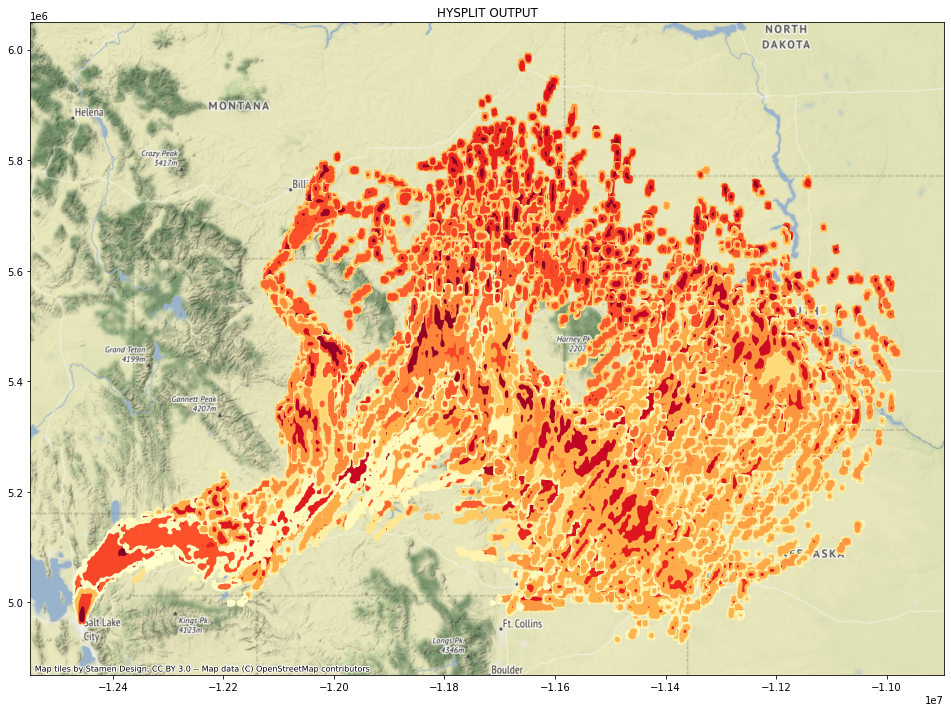

In [77]:
#Plot the sensor locations
f,ax = plt.subplots(1,1,figsize=(24,12))

#plot the location
directory= './SULF_90_01_01_00/'
for files in os.listdir(directory):
    data = gpd.read_file(directory+files)
    data = data.to_crs({'init': 'epsg:3857'})
    data['CONC'] = data['CONC'].astype(float)
    data.plot(cmap='YlOrRd',ax=ax)

ax.set_title('HYSPLIT OUTPUT')
ctx.add_basemap(ax)
